In [1]:
# Set up
%pylab inline
# Libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn.apionly as sns
#
REGDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Lung/QuadraticReg/"

Populating the interactive namespace from numpy and matplotlib


In [22]:
regress = pd.read_csv(os.path.join(REGDIR, "quadratic_reg_out.table"), sep="\t")
permuted = pd.read_csv(os.path.join(REGDIR,"quadratic_reg_out_perm.table"), sep="\t")
print(regress.shape, permuted.shape)
regress = regress.loc[regress["delta_aic[Lin-Quad]"]!='None']
permuted = permuted.loc[permuted["delta_aic[Lin-Quad]"]!='None']
regress["delta_aic[Lin-Quad]"] = regress["delta_aic[Lin-Quad]"].astype(float)
permuted["delta_aic[Lin-Quad]"] = permuted["delta_aic[Lin-Quad]"].astype(float)
regress = regress.replace([np.inf], np.nan)
permuted = permuted.replace([np.inf], np.nan)
L=list(regress["delta_aic[Lin-Quad]"])
print(len(L), max(L), min(L))

(94386, 18) (94386, 18)
94229 18371.773405264114 -2841.3230529108596


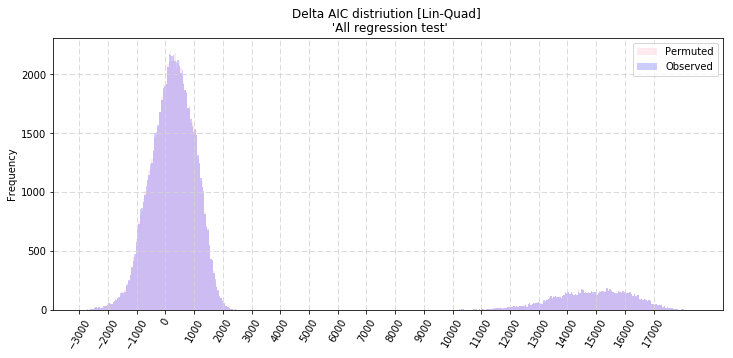

In [23]:
bin_values = np.arange(start=min(L), stop=max(L), step=50)
permuted["delta_aic[Lin-Quad]"].plot(kind='hist', bins=bin_values, figsize=[12,5], alpha=.3, legend=True, label='Permuted', color='pink')
regress["delta_aic[Lin-Quad]"].plot(kind='hist', bins=bin_values, figsize=[12,5], alpha=.2, legend=True, label='Observed', color='blue')
plt.xticks(np.arange(-3000, 18000, 1000), rotation=60)
plt.grid(color='lightgrey', linestyle='--')
plt.title("Delta AIC distriution [Lin-Quad] \n 'All regression test'")
plt.show()

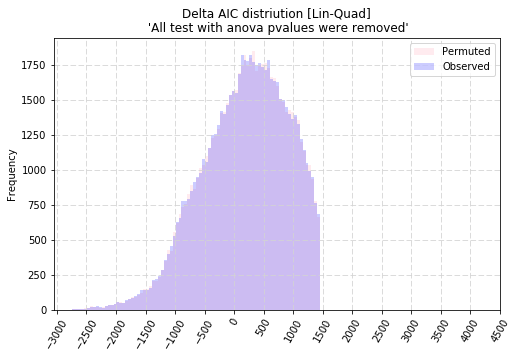

(69143, 18)

In [25]:
#When we remove null pvalues
N = regress.shape[0]
regress = regress.loc[regress['anova_pva'].astype(float)>0]
permuted = permuted.loc[permuted['anova_pva'].astype(float)>0]
L=list(regress["delta_aic[Lin-Quad]"])
bin_values = np.arange(start=min(L), stop=max(L), step=50)

permuted["delta_aic[Lin-Quad]"].plot(kind='hist', bins=bin_values, figsize=[8,5], alpha=.3, legend=True, label='Permuted', color='pink')
regress["delta_aic[Lin-Quad]"].plot(kind='hist', bins=bin_values, figsize=[8,5], alpha=.2, legend=True, label='Observed', color='blue')
plt.xticks(np.arange(-3000, 5000, 500), rotation=60)
plt.grid(color='lightgrey', linestyle='--')
plt.title("Delta AIC distriution [Lin-Quad]\n 'All test with anova pvalues were removed'")
plt.show()
regress.shape

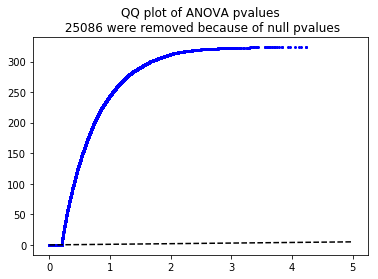

In [26]:
#X = [x for x in range(len(L))]
unif = sorted(list(np.random.uniform(low=0, high=1, size=len(L))))
unif_log = [-1*np.log10(x) for x in unif]

pvals = sorted(list(regress["anova_pva"].astype(float)))
pvals_log = [-1*np.log10(x) for x in pvals]

plt.plot([0,5],[0,5], color="black", linestyle='--')
plt.scatter(unif_log, pvals_log, color='blue', label="Observed pvalues", s=4)
plt.title("QQ plot of ANOVA pvalues\n "+str(N-regress.shape[0])+" were removed because of null pvalues")
plt.show()